<a href="https://colab.research.google.com/github/heinohen/TKO_7092_evaluation_of_machine_learning_models/blob/main/EMLM_Exercise1_heinonen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Henrik Heinonen
* HIDDEN
* 2025-01-30



# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2025

##### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it. Please, add your full name to the file name.
    - The exercise will be graded by a maximum of 2 points.
    - Submit to moodle your solution on ** Wednesday 5 of February ** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br>
Submissions with identical or similar code will result in a failure for the exercise.</b>

## Google drive mount

I run these exercises at Google colab as my own computer is so bad that it might not even run all ML stuff.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
# In this cell import all libraries you need. For example:
import numpy as np
import pandas as pd
from scipy.stats import somersd
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p>

In the following cell:
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [ ]:
# Read the file water_data.csv
df = pd.read_csv('/content/drive/MyDrive/datasets/water_data.csv')

In [ ]:
# Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
print(f'Rows: {df.shape[0]}, Colums: {df.shape[1]}')
df.head(5)

Rows: 225, Colums: 6


,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0.0,0.0,0.0,-0.999216,-0.714208,-0.414911
1,0.0,0.0,0.0,-0.990800,-0.714373,-0.238335
2,0.0,0.0,0.0,-0.990539,-0.714125,0.020788
3,14.0,0.0,14.0,-1.001247,-0.713546,0.945465
4,14.0,0.0,14.0,-1.013727,-0.714125,0.569631


In [ ]:
# Identify the inputs and the outputs columns.

# input columns are (Mod1, Mod2, Mod3)
# output columns are (c_total, Cd, Pb)

In [ ]:
inputs = [
    'Mod1',
    'Mod2',
    'Mod3'
]

outputs = [
    'c_total',
    'Cd',
    'Pb'
]

In [ ]:
# Create a 'tag' column based on groups with identical c_total, Cd, and Pb values
df['tag'] = df.groupby(outputs).ngroup() # https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.ngroup.html
print(df.head(5), end = "\n\n")
counts = df['tag'].value_counts()
print(counts.head(5), end = "\n\n")
print(f'count of all groups: {len(counts)}', end="\n\n")
print("Provide the number of mixtures with 3 replicas and 4 replicas, respectively.")
print(f'count of groups with 3 replicates: {len(counts[counts == 3])}')
print(f'count of groups with 4 replicates: {len(counts[counts == 4])}')
print(f'{len(counts[counts == 3])} + {len(counts[counts == 4])} = {len(counts[counts == 3]) + len(counts[counts == 4])}')

   c_total   Cd    Pb      Mod1      Mod2      Mod3  tag
0      0.0  0.0   0.0 -0.999216 -0.714208 -0.414911    0
1      0.0  0.0   0.0 -0.990800 -0.714373 -0.238335    0
2      0.0  0.0   0.0 -0.990539 -0.714125  0.020788    0
3     14.0  0.0  14.0 -1.001247 -0.713546  0.945465    1
4     14.0  0.0  14.0 -1.013727 -0.714125  0.569631    1

tag
33    4
32    4
24    4
25    4
26    4
Name: count, dtype: int64

count of all groups: 67

Provide the number of mixtures with 3 replicas and 4 replicas, respectively.
count of groups with 3 replicates: 43
count of groups with 4 replicates: 24
43 + 24 = 67


## C-index code

In [ ]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

# notes:
# this seems to only accept the whole prediction vectors and not individual rows so i have to make splits for the leaveoneout manually?
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.somersd.html

def cindex(true, pred):
  """
Parameters
----------
true : array_like
    1D array of rankings, treated as the (row) independent variable. Alternatively, a 2D contingency table.
pred : array_like, optional
    If x is a 1D array of rankings, y is a 1D array of rankings of the same length, treated as the (column) dependent variable. If x is 2D, y is ignored.
"""
  s_d = somersd(true, y=pred, alternative='two-sided')
  c_index = (s_d.statistic + 1.0)/2.0
  return c_index

## Functions

## Results for Leave-One-Out cross-validation

In [ ]:
# PLAN

# testing with knnregressor not working with usual knn = KNNeighborsRegressor(n_neighbors=5) and fit and use cross_val_score ==> returns nan's for somersd
# scoring function accepts only arrays of equal length

# SETUP
loo = LeaveOneOut()
k_array = [1, 3, 5, 7] # from the assignment

loo_results = {} # this holds all of the results for all 3 outputs and 4 c_index_values for k=1,3,5,7

X = df[inputs].values

for o in outputs:
  print(f'output == {o}')
  individual_output_results = {}
  y = df[o].values # target value
  # FOR LOOP FOR THE KNN
  for k in k_array:
    print(f'k == {k}')
    knn = KNeighborsRegressor(n_neighbors=k)

    tvs = [] # true values
    preds = [] # predictions


    # # https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.LeaveOneOut.html
    #print(loo.get_n_splits(X))
    #print(loo)

    for i, (train_index, test_index) in enumerate(loo.split(X)):
        #print(f"Fold {i}:")
        #print(f"  Train: index={X[train_index]}") # from here we get the splitted indexes
        #print(f"  Test:  index={X[test_index]}") # this is the individual test index
        #print(f"  Test:  index={y[train_index]}") # this is the individual test index
        #print(f"  Test:  index={y[test_index]}") # this is the individual test index
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # train
        knn.fit(X_train, y_train)

        # predict
        y_pred = knn.predict(X_test)

        #print(f'TRUE TEST VALUE: {y_test[0]}')
        tvs.append(y_test[0])
        #print(f'PREDICTED VALUE: {y_pred[0]}')
        preds.append(y_pred[0])

    # call the custom scoring function
    c_index_value = cindex(true=tvs, pred=preds)
    print(f"C-index value: {c_index_value}")
    individual_output_results[k] = c_index_value # store key: k, value: cindex

  loo_results[o] = individual_output_results # store key: o, value is dict of key:k, value: cindex




output == c_total
k == 1
C-index value: 0.9082833811137173
k == 3
C-index value: 0.9141907740422205
k == 5
C-index value: 0.8941012944140387
k == 7
C-index value: 0.8737294761532447
output == Cd
k == 1
C-index value: 0.921869127656909
k == 3
C-index value: 0.8995907629348143
k == 5
C-index value: 0.8619660082682591
k == 7
C-index value: 0.8141520858562659
output == Pb
k == 1
C-index value: 0.8805487117384223
k == 3
C-index value: 0.8744519146448406
k == 5
C-index value: 0.8542614941328768
k == 7
C-index value: 0.8355326345680043


## Results for Leave-Replicas-Out cross-validation

In [ ]:
# require data set containing non-independent replicates

# ALGO from the lecture materials:

# 1 Split the data into n_groups where a group is formed by all replicates
# 2 for i = 1 to n_groups do:
# 3   train model on all but the data_group[i]
# 4   predict outpits for the data_group[i]
# 5 calculate performance measure for true and predicted outputs



# did not find a model for 'Leave-Replicas-Out', by definition this seemed closest:
# https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

# SETUP
log = LeaveOneGroupOut()
log_results = {} # this holds all of the results for all 3 outputs and 4 c_index_values for k=1,3,5,7

X = df[inputs].values
#print(X)

groups = df['tag'].values
#print(groups)

for o in outputs:
  print(f'output == {o}')
  individual_output_results = {}
  y = df[o].values # target value
  # FOR LOOP FOR THE KNN
  for k in k_array:
    print(f'k == {k}')
    #model
    knn = KNeighborsRegressor(n_neighbors=k)

    tvs = [] # true values
    preds = [] # predictions

    # this needs to be one value array, so for loop before
    y = df[o].values
    #print(y)

    #log.get_n_splits(groups=groups)
    for i, (train_index, test_index) in enumerate(log.split(X,y,groups)):
      #print(f"Fold {i}:")
      #print(f"  Train: index={train_index}, group={groups[train_index]}")
      #print(f"  Test:  index={test_index}, group={groups[test_index]}")
      # split to train and test
      X_train, X_test = X[train_index], X[test_index] # all 3 features
      y_train, y_test = y[train_index], y[test_index] # 1 target

      #print(y_train, y_test)

      # train
      knn.fit(X_train, y_train)

      # predict
      y_pred = knn.predict(X_test)

      #print(f'TRUE TEST VALUE: {y_test[0]}')
      tvs.append(y_test[0])
      #print(f'PREDICTED VALUE: {y_pred[0]}')
      preds.append(y_pred[0])

    # call the custom scoring function
    c_index_value = cindex(true=tvs, pred=preds)
    print(f"C-index value: {c_index_value}")
    individual_output_results[k] = c_index_value # store key: k, value: cindex
  log_results[o] = individual_output_results # store key: o, value is dict of key:k, value: cindex



output == c_total
k == 1
C-index value: 0.8250244379276637
k == 3
C-index value: 0.8338220918866079
k == 5
C-index value: 0.8242913000977516
k == 7
C-index value: 0.8225806451612903
output == Cd
k == 1
C-index value: 0.7921374764595104
k == 3
C-index value: 0.7631826741996234
k == 5
C-index value: 0.737758945386064
k == 7
C-index value: 0.7008003766478342
output == Pb
k == 1
C-index value: 0.7540018832391714
k == 3
C-index value: 0.7688323917137476
k == 5
C-index value: 0.7645951035781544
k == 7
C-index value: 0.7796610169491525


## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

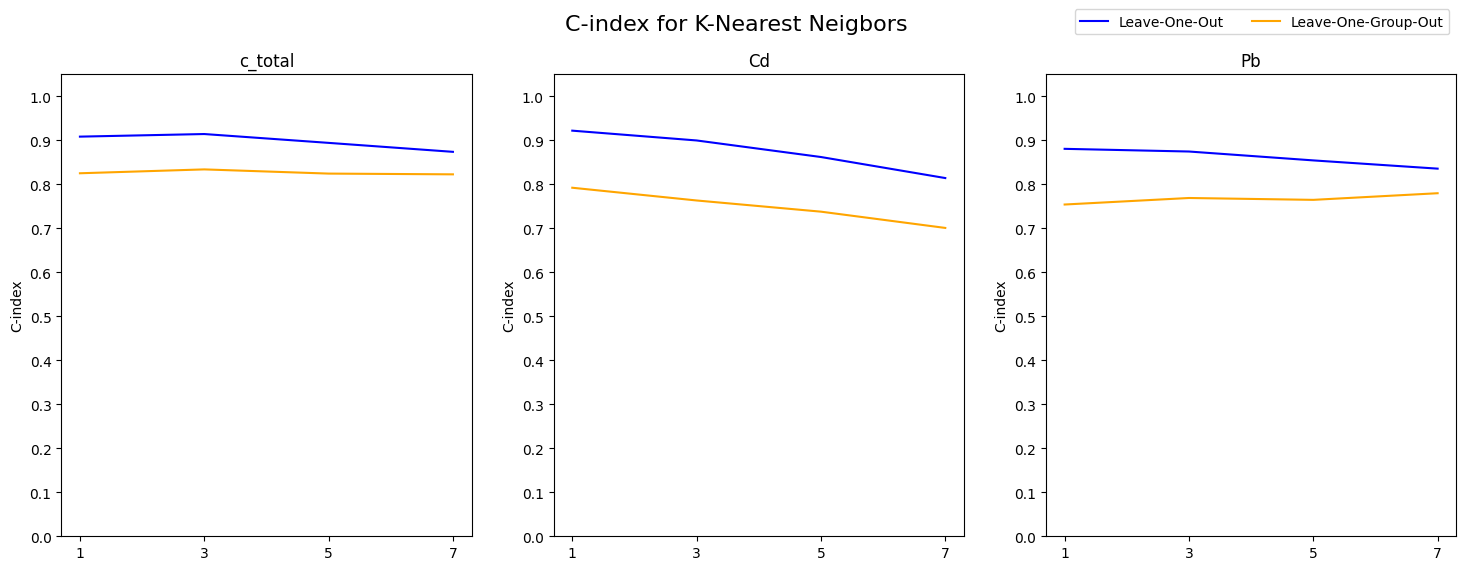

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) #figures, 1 row, 3 subplots
fig.suptitle("C-index for K-Nearest Neigbors", fontsize=16) # header

labels = ["Leave-One-Out", "Leave-One-Group-Out"]

for i, ax in enumerate(axes): # use loop to generate plots
  #plan
  # 1: get by output[i] the key to extract values from loo_results and log_results
  #print(outputs[i])
  o = outputs[i]
  loo_one_variable = loo_results[outputs[i]]
  log_one_variable = log_results[outputs[i]]

  # as list to use in y variable
  loo_values = list(loo_one_variable.values())
  log_values = list(log_one_variable.values())

  # x in the plot is the k_array values, k = 1,3,5,7
  ax.plot(k_array, loo_values, color='blue', label=labels[0])  # plot loo
  ax.plot(k_array, log_values, color='orange', label=labels[1])   # plot log
  ax.set_ylim(0,1.05) # set ylim to go above 1.0 to leave room
  ax.set_xticks(k_array) # set xticks to resemble the moodle material
  ax.set_ylabel("C-index") # set ylabel to resemble the moodle material
  ax.set_yticks(np.arange(0, 1.1, 0.1))  # set yticks, start at 0, end at 1, with step 0.1
  ax.set_title(f'{o}') # set title to resemble the moodle material

handles, labels = axes[0].get_legend_handles_labels() # https://matplotlib.org/stable/users/explain/axes/legend_guide.html#sphx-glr-users-explain-axes-legend-guide-py
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 1), ncol=2) # generates legend with handles and labels bboxed to (x,y) "top right", ncol=2 makes sidebyside
plt.show()


## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:

1. Leave-One-Out seems to hold the performance better with such a small data set but seems to decrease in performance level when k-count increases. i would assume that if we had more data the leave-one-out would bear a higher risk of overfitting as the measurements are not independent.
2. Leave-One-Group-Out holds the performance level better where Leave-One-Out seems to dip. This is due the training data not leaking into the evaluation set.

### convert to pdf

In [ ]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc &> ~/apt-log.txt # to hide the output
!pip3 install -q pypandoc

!cp drive/MyDrive/Colab\ Notebooks/EMLM_Exercise1_heinonen.ipynb ./
!jupyter nbconvert --to PDF "EMLM_Exercise1_heinonen.ipynb"

[NbConvertApp] Converting notebook EMLM_Exercise1_heinonen.ipynb to PDF
[NbConvertApp] Support files will be in EMLM_Exercise1_heinonen_files/
[NbConvertApp] Making directory ./EMLM_Exercise1_heinonen_files
[NbConvertApp] Writing 51926 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 101865 bytes to EMLM_Exercise1_heinonen.pdf
